<a href="https://colab.research.google.com/github/heec12/SZ-detection/blob/main/FCN_SZ_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First version: 4 conv layers, using CrossEntropyLoss function

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp28: 76.44


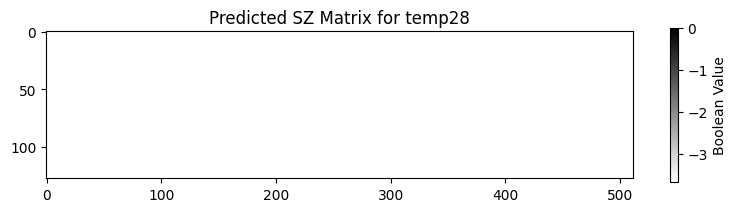

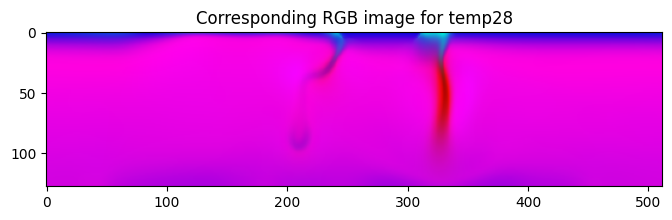

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp29: 116.98


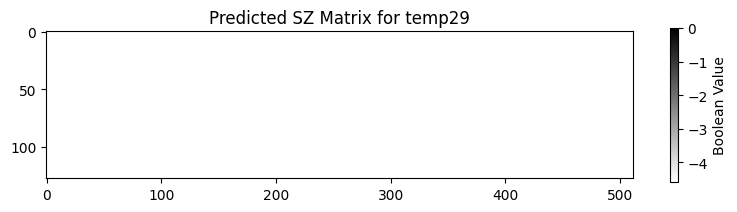

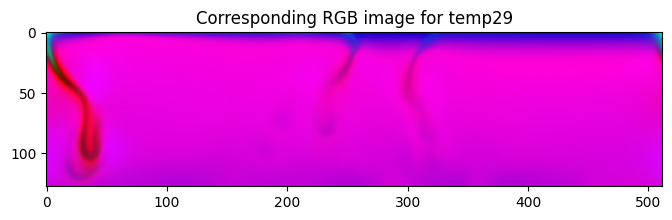

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp30: 82.36


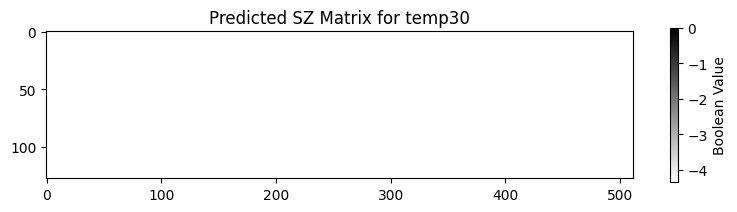

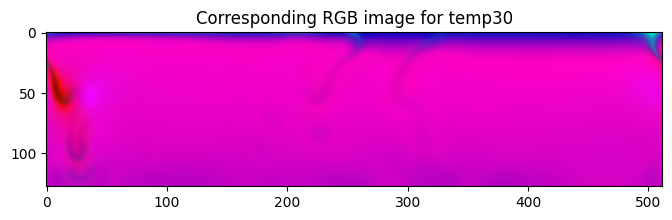

Output shape: torch.Size([128, 512]), Target Shape: torch.Size([128, 512])
Average loss for temp31: 67.73


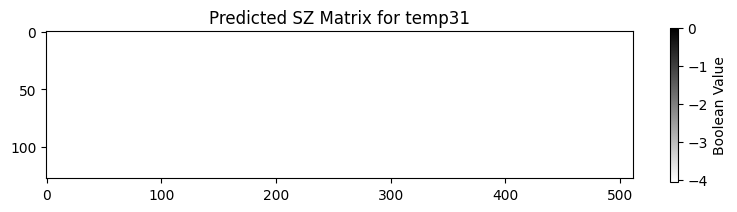

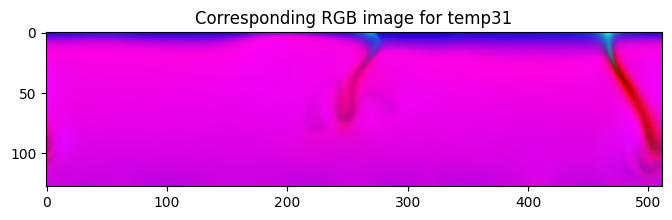

In [ ]:
import torch
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# Define the FCN model
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        x = self.conv1(x) # Make sure input 'x' has 3 channels
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        return x

# Function to train the model
def train_model(model, criterion, optimizer, X_train, y_train, device, epochs=12):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x = torch.tensor(X_train[i], device=device).float()
            y = y_train[i]
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
                                        # from torch.Size([1, 1, 128, 512])
                                        # to torch.Size([128, 512])
            loss = criterion(outputs, y) # Use binary cross entropy loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss for the epoch
        #print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0.0 # Initialize total_loss here
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
                                        # from torch.Size([1, 1, 128, 512])
                                        # to torch.Size([128, 512])
            loss = criterion(outputs, y)
            total_loss += loss.item()

            # Visualize the output and target shapes
            print(f"Output shape: {outputs.shape}, Target Shape: {y.shape}")

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs
    # Return average loss instead of accuracy

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    #plt.imshow(y_matrix, cmap='binary')
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    #plt.xlabel('Width')
    #plt.ylabel('Height')
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    # Convert the tensor to a NumPy array
    np_array = loaded_tensor_rgb.cpu().numpy()
    # Plot the image
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the image using torch.load
#loaded_tensor = torch.load('/content/gdrive/MyDrive/rgbs/temp0.pt')
# Convert the tensor to correct shape
#reshaped_tensor=torch.permute(loaded_tensor, (2, 0, 1))
# Convert the tensor to float and scale to the range [0, 1]
#reshaped_tensor = reshaped_tensor.float() / 255.0
# Convert the tensor to a PIL image
#image = transforms.ToPILImage()(reshaped_tensor)


# Initialize model, criterion, optimizer
model = FCN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(50):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.LongTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].cpu().numpy().reshape(-1, 3, 128, 512)
    y_train = y_train_all[i]

    train_model(model, criterion, optimizer, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i+4}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    # Reshape to [batch_size, channels, height, width]
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.LongTensor)

    #accuracy = evaluate_model(model, criterion, X_eval, y_eval, device)
    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    print(f"Average loss for {input_temp1}: {average_loss:.2f}")

    ## Assuming y_eval is a boolean matrix of size [128, 512], reshape it accordingly
    #y_matrix = y_eval.cpu().numpy().reshape(128, 512)
    #plot_results(y_matrix, f'Predicted SZ Matrix for {input_temp1}')
    #plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


improved version: 6 conv layers, using BCEWithLogitsLoss for binary classification problem, adjusting the learning rate, data augmentation, adding weighted loss, dice loss, attention mechanisms (SE blocks), and post-processing for thresholding the outputs.

1. Data Augmentation and Preprocessing:
Class Balance: Ensure that your dataset is balanced between subduction zones
and non-subduction zones. This can help the model distinguish better.
Additional Augmentation: Introduce more diverse augmentation techniques such as brightness/contrast adjustment, random cropping, or adding Gaussian noise. This can make the model more robust to different variations in the input images.
2. Model Architecture and Training:
Additional Layers: Introduce more convolutional layers or add residual connections to make the network deeper and capable of capturing more complex features.
Attention Mechanisms: Implement attention mechanisms like SE blocks (Squeeze-and-Excitation) or self-attention layers to help the model focus on relevant features.
3. Loss Function and Metrics:
Weighted Loss: If the model is confusing the cold lithosphere with subduction zones, consider using a weighted loss function that penalizes false positives more.
Dice Loss: Combine BCEWithLogitsLoss with Dice Loss to handle class imbalance better and improve segmentation performance.
Evaluation Metrics: Monitor additional metrics like Precision, Recall, and F1-Score, which can provide more insights than just the loss value.
4. Post-Processing:
Thresholding: Apply a threshold to the model outputs to fine-tune the decision boundary for classifying subduction zones.
Morphological Operations: Use post-processing techniques like dilation, erosion, or connected component analysis to refine the predicted segmentation masks.

Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Epoch 1/10, Loss: 1.6003
Epoch 2/10, Loss: 1.5208
Epoch 3/10, Loss: 1.6027
Epoch 4/10, Loss: 1.5828
Epoch 5/10, Loss: 1.5806
Epoch 6/10, Loss: 1.5348
Epoch 7/10, Loss: 1.5394
Epoch 8/10, Loss: 1.5649
Epoch 9/10, Loss: 1.5645
Epoch 10/10, Loss: 1.5645
Epoch 1/10, Loss: 1.5003
Epoch 2/10, Loss: 1.5089
Epoch 3/10, Loss: 1.5378
Epoch 4/10, Loss: 1.5390
Epoch 5/10, Loss: 1.5238
Epoch 6/10, Loss: 1.5433
Epoch 7/10, Loss: 1.5382
Epoch 8/10, Loss: 1.5018
Epoch 9/10, Loss: 1.5389
Epoch 10/10, Loss: 1.5151
Epoch 1/10, Loss: 1.5203
Epoch 2/10, Loss: 1.5276
Epoch 3/10, Loss: 1.5508
Epoch 4/10, Loss: 1.5270
Epoch 5/10, Loss: 1.5504
Epoch 6/10, Loss: 1.5534
Epoch 7/10, Loss: 1.5051
Epoch 8/10, Loss: 1.5568
Epoch 9/10, Loss: 1.5506
Epoch 10/10, Loss: 1.5514
Epoch 1/10, Loss: 1.5433
Epoch 2/10, Loss: 1.5327
Epoch 3/10, Loss: 1.5356
Epoch 4/10, Loss: 1.4947
Epoch 5/10, Loss: 1.4890
Epoch 6/10, Loss: 1.4865
Epoch 7/10, Loss: 1.5133
Epoch 8/10, Loss: 1.4852
Epoch 9/10, Loss: 1.4850
Epoch 10/10, Loss: 1.4

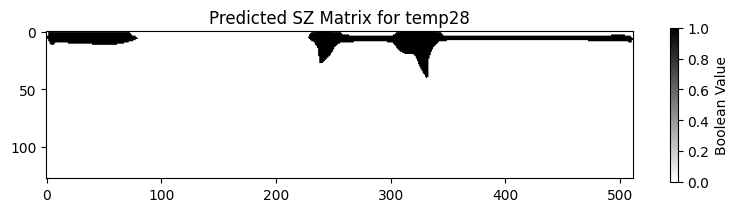

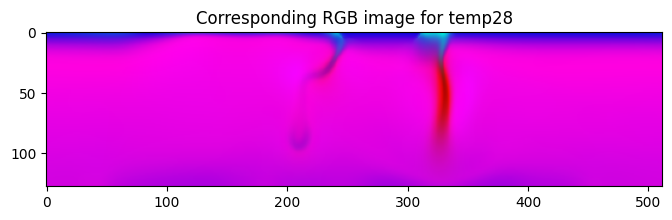

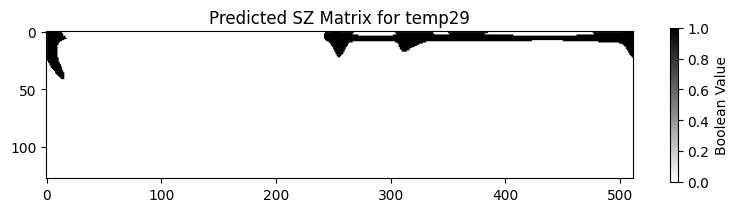

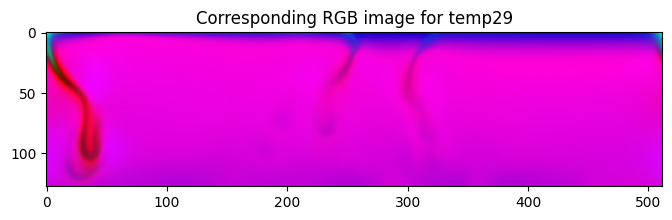

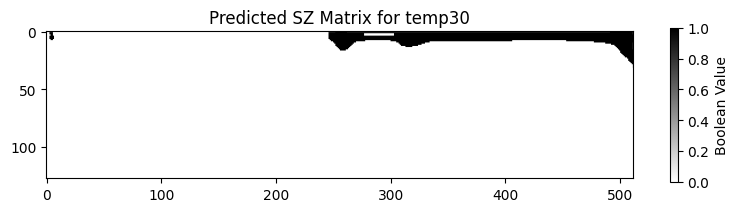

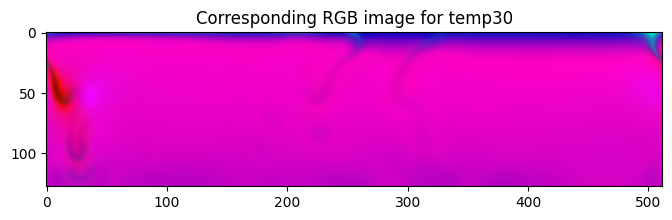

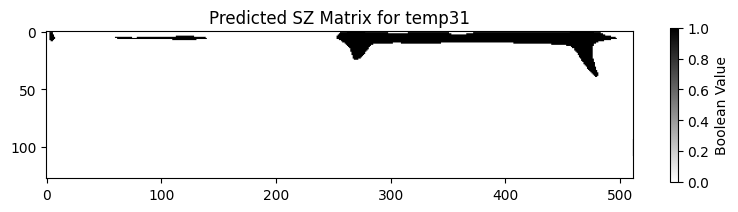

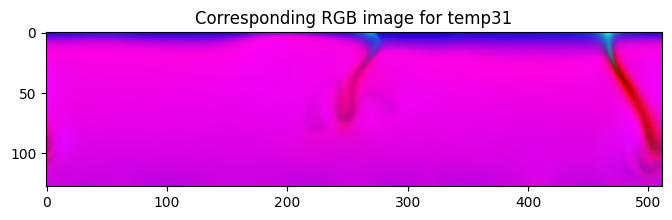

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# SE Block for attention mechanism
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = torch.mean(x, dim=(2, 3), keepdim=True)
        scale = torch.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Define the FCN model with improvements
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SEBlock(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.se4 = SEBlock(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.se5 = SEBlock(32)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.se1(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.upsample(x)
        x = self.bn4(self.conv4(x))
        x = self.se4(x)
        x = self.upsample(x)
        x = self.bn5(self.conv5(x))
        x = self.se5(x)
        x = self.conv6(x)
        return x

# Function for manual data augmentation
def augment_data(x, y):
    if random.random() > 0.5:
        x = torch.flip(x, [2])  # Horizontal flip
        y = torch.flip(y, [0])
    if random.random() > 0.5:
        x = torch.flip(x, [1])  # Vertical flip
        y = torch.flip(y, [1])
    if random.random() > 0.5:
        angle = random.randint(-10, 10)  # Random rotation between -10 and 10 degrees
        x = rotate_tensor(x, angle)
        y = rotate_tensor(y.unsqueeze(0), angle).squeeze(0)
    return x, y

def rotate_tensor(tensor, angle):
    angle = np.deg2rad(angle)
    rotation_matrix = torch.tensor([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    grid = nn.functional.affine_grid(rotation_matrix.unsqueeze(0)[:, :2, :].float(), tensor.unsqueeze(0).size())
    tensor = nn.functional.grid_sample(tensor.unsqueeze(0), grid)
    return tensor.squeeze(0)

# Dice Loss function
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth))

# Combined BCEWithLogitsLoss and Dice Loss
def combined_loss(pred, target):
    bce_loss = nn.BCEWithLogitsLoss()(pred, target)
    d_loss = dice_loss(pred, target)
    return bce_loss + d_loss

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, X_train, y_train, device, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x, y = augment_data(X_train[i], y_train[i])  # Apply augmentation
            x = x.to(device).float()
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y) # Use combined loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust the learning rate
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y)
            total_loss += loss.item()

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs

# Post-processing function
def post_process(outputs, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    return outputs

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    np_array = loaded_tensor_rgb.cpu().numpy()
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer, and scheduler
model = FCN().to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(50):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.FloatTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].unsqueeze(0) # Keep X_train as a PyTorch tensor
    X_train = X_train.permute(0, 3, 1, 2)  # Permute the dimensions to match the expected input shape [batch, channels, height, width]
    y_train = y_train_all[i]

    train_model(model, criterion, optimizer, scheduler, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.FloatTensor)

    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    outputs = post_process(outputs)
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


Below is the training set using 'temp - ha_temp' field as blue

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch 1/7, Loss: 1.5813
Epoch 2/7, Loss: 1.4806
Epoch 3/7, Loss: 1.6688
Epoch 4/7, Loss: 1.6222
Epoch 5/7, Loss: 1.4958
Epoch 6/7, Loss: 1.5858
Epoch 7/7, Loss: 1.5866
Epoch 1/7, Loss: 1.4940
Epoch 2/7, Loss: 1.4397
Epoch 3/7, Loss: 1.5648
Epoch 4/7, Loss: 1.5655
Epoch 5/7, Loss: 1.5649
Epoch 6/7, Loss: 1.4876
Epoch 7/7, Loss: 1.4270
Epoch 1/7, Loss: 1.4551
Epoch 2/7, Loss: 1.4542
Epoch 3/7, Loss: 1.4884
Epoch 4/7, Loss: 1.4722
Epoch 5/7, Loss: 1.4547
Epoch 6/7, Loss: 1.4542
Epoch 7/7, Loss: 1.5781
Epoch 1/7, Loss: 1.5621
Epoch 2/7, Loss: 1.5681
Epoch 3/7, Loss: 1.5695
Epoch 4/7, Loss: 1.5656
Epoch 5/7, Loss: 1.4290
Epoch 6/7, Loss: 1.5624
Epoch 7/7, Loss: 1.4297
Epoch 1/7, Loss: 1.5753
Epoch 2/7, Loss: 1.5701
Epoch 3/7, Loss: 1.5980
Epoch 4/7, Loss: 1.5729
Epoch 5/7, Loss: 1.5755
Epoch 6/7, Loss: 1.5866
Epoch 7/7, Loss: 1.5749
Epoch 1/7, Loss: 1.4548
Epoch

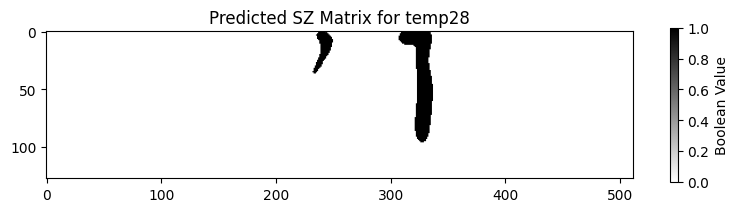

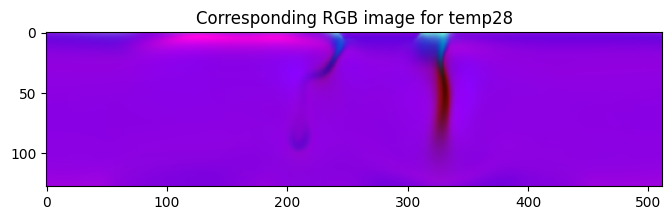

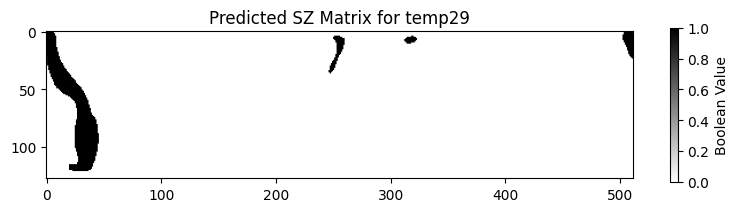

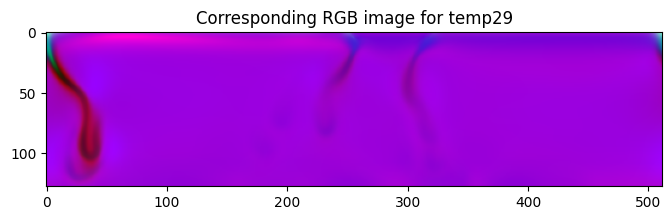

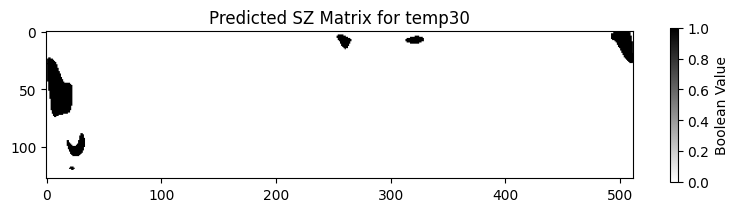

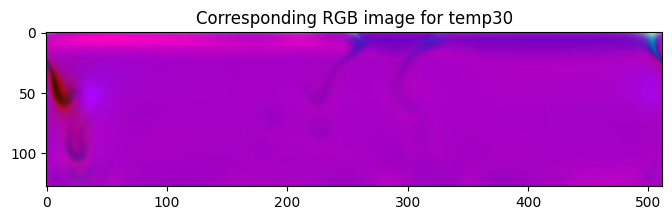

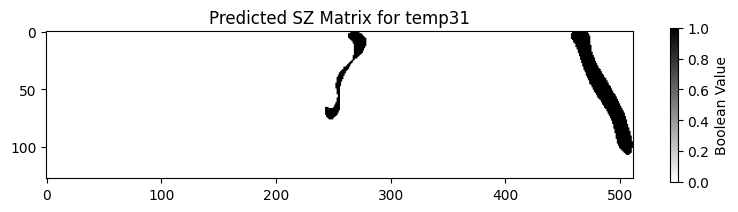

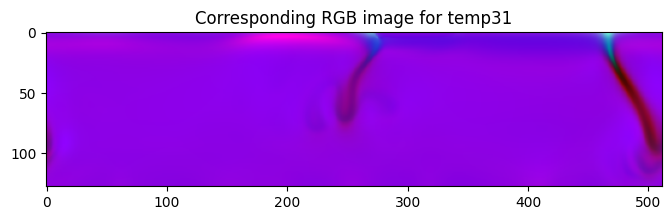

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# SE Block for attention mechanism
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = torch.mean(x, dim=(2, 3), keepdim=True)
        scale = torch.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Define the FCN model with improvements
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SEBlock(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.se4 = SEBlock(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.se5 = SEBlock(32)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.se1(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.upsample(x)
        x = self.bn4(self.conv4(x))
        x = self.se4(x)
        x = self.upsample(x)
        x = self.bn5(self.conv5(x))
        x = self.se5(x)
        x = self.conv6(x)
        return x

# Function for manual data augmentation
def augment_data(x, y):
    if random.random() > 0.5:
        x = torch.flip(x, [2])  # Horizontal flip
        y = torch.flip(y, [0])
    if random.random() > 0.5:
        x = torch.flip(x, [1])  # Vertical flip
        y = torch.flip(y, [1])
    if random.random() > 0.5:
        angle = random.randint(-10, 10)  # Random rotation between -10 and 10 degrees
        x = rotate_tensor(x, angle)
        y = rotate_tensor(y.unsqueeze(0), angle).squeeze(0)
    return x, y

def rotate_tensor(tensor, angle):
    angle = np.deg2rad(angle)
    rotation_matrix = torch.tensor([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    grid = nn.functional.affine_grid(rotation_matrix.unsqueeze(0)[:, :2, :].float(), tensor.unsqueeze(0).size())
    tensor = nn.functional.grid_sample(tensor.unsqueeze(0), grid)
    return tensor.squeeze(0)

# Dice Loss function
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth))

# Combined BCEWithLogitsLoss and Dice Loss
def combined_loss(pred, target):
    bce_loss = nn.BCEWithLogitsLoss()(pred, target)
    d_loss = dice_loss(pred, target)
    return bce_loss + d_loss

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, X_train, y_train, device, epochs=7):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x, y = augment_data(X_train[i], y_train[i])  # Apply augmentation
            x = x.to(device).float()
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y) # Use combined loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust the learning rate
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y)
            total_loss += loss.item()

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs

# Post-processing function
def post_process(outputs, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    return outputs

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    np_array = loaded_tensor_rgb.cpu().numpy()
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer, and scheduler
model = FCN().to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(50):
    input_temp1 = 'temp' + str(i)
    input_temp_ha = 'ha_temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp_ha}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.FloatTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].unsqueeze(0) # Keep X_train as a PyTorch tensor
    X_train = X_train.permute(0, 3, 1, 2)  # Permute the dimensions to match the expected input shape [batch, channels, height, width]
    y_train = y_train_all[i]

    train_model(model, criterion, optimizer, scheduler, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    input_temp_ha = 'ha_temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp_ha}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.FloatTensor)

    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    outputs = post_process(outputs)
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


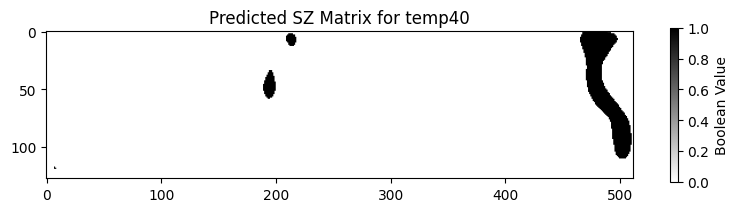

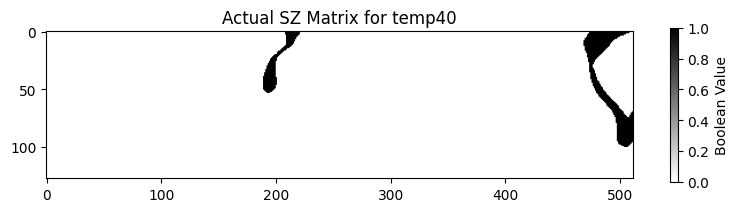

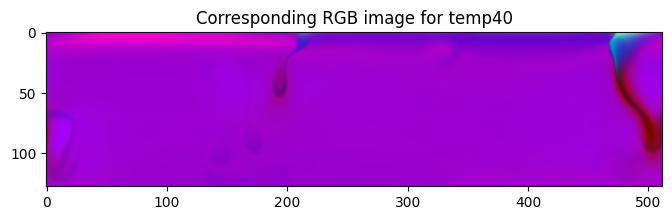

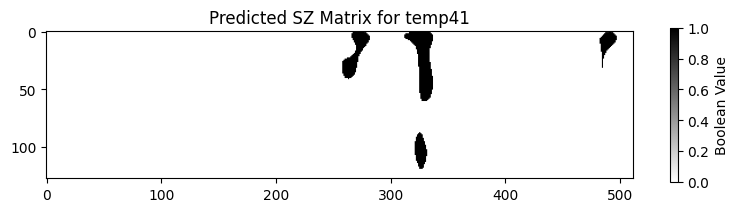

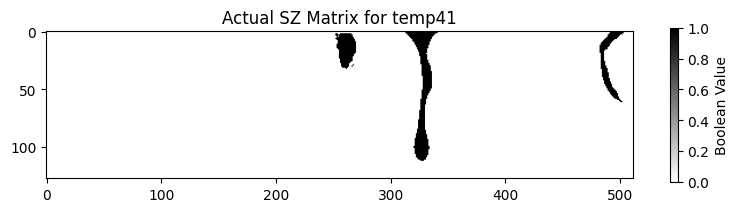

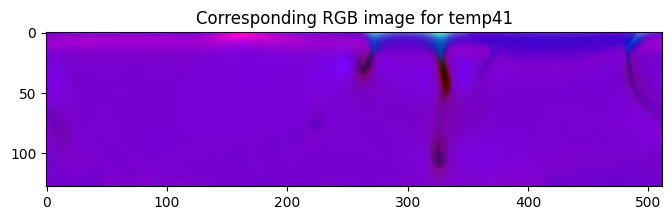

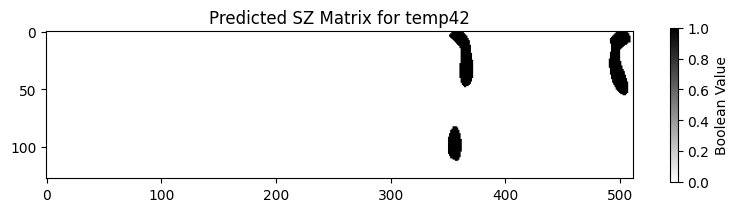

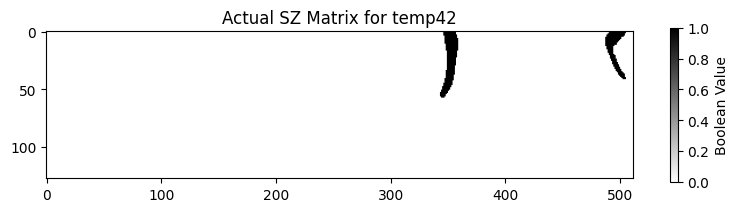

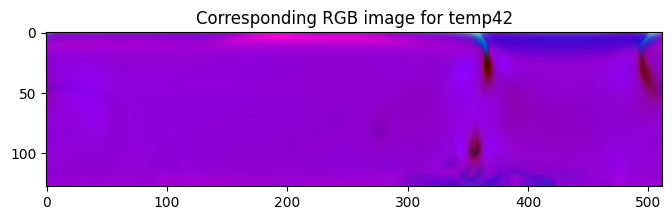

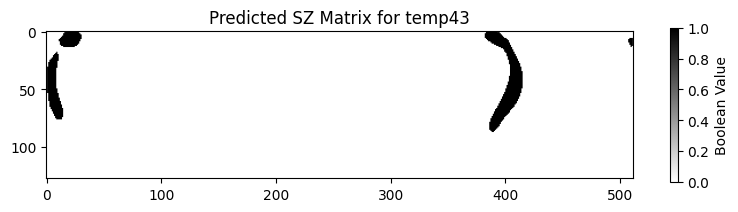

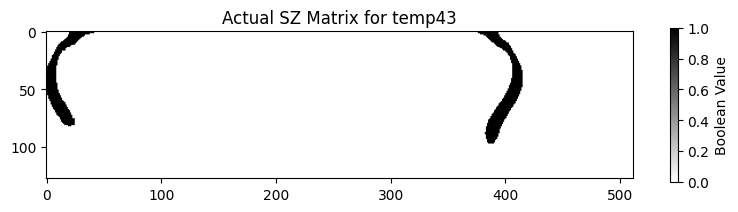

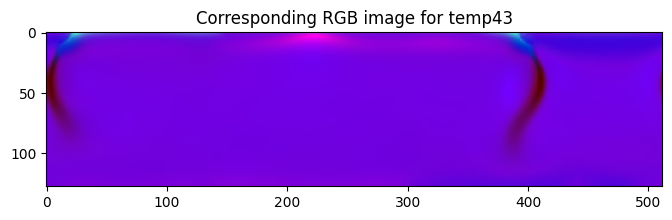

In [ ]:
# Function to create a predicted SZ
def plot_actual(y_matrix, title):
    y_matrix = y_matrix.squeeze(0)
    plt.figure(figsize=(8, 2))
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Evaluation loop
for i in range(40, 44):
    input_temp1 = 'temp' + str(i)
    input_temp_ha = 'ha_temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp_ha}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.FloatTensor)

    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    outputs = post_process(outputs)
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_actual(y_eval.cpu().numpy(), f'Actual SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

In [ ]:
# Opening the final model "trained_model_fcn_final.pt" from the google drive

# Load the trained model
model = FCN().to(device)  # Initialize the model
model.load_state_dict(torch.load('/content/gdrive/MyDrive/trained_model_fcn_final.pt'))
model.eval()  # Set the model to evaluation mode



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# SE Block for attention mechanism
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = torch.mean(x, dim=(2, 3), keepdim=True)
        scale = torch.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Define the FCN model with improvements
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SEBlock(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.se4 = SEBlock(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.se5 = SEBlock(32)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.se1(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.upsample(x)
        x = self.bn4(self.conv4(x))
        x = self.se4(x)
        x = self.upsample(x)
        x = self.bn5(self.conv5(x))
        x = self.se5(x)
        x = self.conv6(x)
        return x

# Function for manual data augmentation
def augment_data(x, y):
    if random.random() > 0.5:
        x = torch.flip(x, [2])  # Horizontal flip
        y = torch.flip(y, [0])
    if random.random() > 0.5:
        x = torch.flip(x, [1])  # Vertical flip
        y = torch.flip(y, [1])
    if random.random() > 0.5:
        angle = random.randint(-10, 10)  # Random rotation between -10 and 10 degrees
        x = rotate_tensor(x, angle)
        y = rotate_tensor(y.unsqueeze(0), angle).squeeze(0)
    return x, y

def rotate_tensor(tensor, angle):
    angle = np.deg2rad(angle)
    rotation_matrix = torch.tensor([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    grid = nn.functional.affine_grid(rotation_matrix.unsqueeze(0)[:, :2, :].float(), tensor.unsqueeze(0).size())
    tensor = nn.functional.grid_sample(tensor.unsqueeze(0), grid)
    return tensor.squeeze(0)

# Dice Loss function
def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - ((2.0 * intersection + smooth) / (pred.sum() + target.sum() + smooth))

# Combined BCEWithLogitsLoss and Dice Loss
def combined_loss(pred, target):
    bce_loss = nn.BCEWithLogitsLoss()(pred, target)
    d_loss = dice_loss(pred, target)
    return bce_loss + d_loss

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, X_train, y_train, device, epochs=7):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x, y = augment_data(X_train[i], y_train[i])  # Apply augmentation
            x = x.to(device).float()
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y) # Use combined loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust the learning rate
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze() # To match the dimension
            loss = criterion(outputs, y)
            total_loss += loss.item()

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs

# Post-processing function
def post_process(outputs, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    return outputs

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    np_array = loaded_tensor_rgb.cpu().numpy()
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer, and scheduler
model = FCN().to(device)
criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(50):
    input_temp1 = 'temp' + str(i)
    input_temp_visc = 'visc_temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp_visc}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.FloatTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].unsqueeze(0) # Keep X_train as a PyTorch tensor
    X_train = X_train.permute(0, 3, 1, 2)  # Permute the dimensions to match the expected input shape [batch, channels, height, width]
    y_train = y_train_all[i]

    train_model(model, criterion, optimizer, scheduler, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    input_temp_visc = 'visc_temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp_visc}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.FloatTensor)

    average_loss, outputs = evaluate_model(model, criterion, X_eval, y_eval, device)
    outputs = post_process(outputs)
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


Mounted at /content/gdrive


Unet structure

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

# SE Block for attention mechanism
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = torch.mean(x, dim=(2, 3), keepdim=True)
        scale = torch.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Define the FCN model with improvements
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.se1 = SEBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.se2 = SEBlock(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.se3 = SEBlock(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.se4 = SEBlock(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.se5 = SEBlock(32)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.se1(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn2(self.conv2(x)))
        x = self.se2(x)
        x = self.maxpool(x)
        x = self.dropout(self.bn3(self.conv3(x)))
        x = self.se3(x)
        x = self.upsample(x)
        x = self.bn4(self.conv4(x))
        x = self.se4(x)
        x = self.upsample(x)
        x = self.bn5(self.conv5(x))
        x = self.se5(x)
        x = self.conv6(x)
        return x

# Function for manual data augmentation
def augment_data(x, y):
    print("Shape of x before augmentation:", x.shape)
    print("Shape of y before augmentation:", y.shape)

    if random.random() > 0.5:
        x = torch.flip(x, [2])  # Horizontal flip
        y = torch.flip(y, [0])
        print("Flipped horizontally")
    if random.random() > 0.5:
        x = torch.flip(x, [1])  # Vertical flip
        y = torch.flip(y, [1])
        print("Flipped vertically")
    if random.random() > 0.5:
        angle = random.randint(-10, 10)  # Random rotation
        x = rotate_tensor(x, angle)
        y = rotate_tensor(y.unsqueeze(0), angle).squeeze(0)
        print("Rotated by", angle, "degrees")
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)  # Random scaling
        x = scale_tensor(x, scale)
        # Correct the dimensions for interpolation by applying the same scaling to y
        y = scale_tensor(y.unsqueeze(0), scale).squeeze(0)
        print("Scaled by", scale)

    print("Shape of x after augmentation:", x.shape)
    print("Shape of y after augmentation:", y.shape)

    return x, y

def scale_tensor(tensor, scale):
    # Handle all 2D, 3D and 4D tensors
    if len(tensor.size()) == 2:
        h, w = tensor.size()
    elif len(tensor.size()) == 3:
        _, h, w = tensor.size()
    else:
        _, _, h, w = tensor.size()

    new_h = int(h * scale)
    new_w = int(w * scale)
    # Ensure new_h and new_w are integers by rounding before casting
    # Correct the new_size to be a tuple of (new_h, new_w) for 2D interpolation
    new_size = (new_h, new_w)
    # Squeeze the tensor to remove the single batch dimension if it exists
    tensor = tensor.squeeze(0)
    print("Shape of tensor:", tensor.shape)
    # Use 'nearest' interpolation for the mask to avoid creating new values
    # Add padding to handle cases where new_h is larger than original h
    pad_h = max(0, new_h - h)
    pad_w = max(0, new_w - w)
    tensor = nn.functional.pad(tensor, (0, pad_w, 0, pad_h), mode='constant', value=0)
    # Ensure the tensor is 3D for 2D interpolation
    if len(tensor.size()) == 2:
        tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add a channel dimension if necessary
    elif len(tensor.size()) == 3:
        tensor = tensor.unsqueeze(0)  # Add a channel dimension if necessary
    print("Shape of tensor before interpolate:", tensor.shape)
    tensor = nn.functional.interpolate(tensor, size=new_size, mode='nearest')
    return tensor.squeeze(0) # Return the tensor without squeezing to preserve the batch dimension if it was present

def rotate_tensor(tensor, angle):
    angle = np.deg2rad(angle)
    rotation_matrix = torch.tensor([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    # Ensure the tensor is 3D even after squeezing
    tensor_2d = tensor.squeeze(0)
    if len(tensor_2d.size()) == 2: # Handle the case when tensor_2d is 2D
        tensor_2d = tensor_2d.unsqueeze(0) # Add a channel dimension
    _, h, w = tensor_2d.size()
    # Set align_corners=True for consistency
    grid = nn.functional.affine_grid(rotation_matrix.unsqueeze(0)[:, :2, :].float(), torch.Size((1, 1, h, w)), align_corners=True)
    tensor_2d = nn.functional.grid_sample(tensor_2d.unsqueeze(0), grid, align_corners=True)
    return tensor_2d.squeeze(0).unsqueeze(0)

# Function to calculate class weights
def calculate_class_weights(y_train_all):
    total = sum([torch.sum(y).item() for y in y_train_all])
    weights = [torch.sum(y).item() / total for y in y_train_all]
    class_weights = torch.FloatTensor(weights).to(device)
    return class_weights

# Combined BCEWithLogitsLoss and Dice Loss with class weights
def weighted_combined_loss(pred, target):
    # Convert boolean target to float for BCEWithLogitsLoss
    target = target.float()
    #bce_loss = nn.BCEWithLogitsLoss(pred, target)
    bce_loss_function = nn.BCEWithLogitsLoss() # Create an instance of the loss function
    bce_loss = bce_loss_function(pred, target) # Calculate the BCE loss and store it
    d_loss = dice_loss(pred, target)
    return bce_loss + d_loss # Now you can add the two loss values

# Dice Loss function
def dice_loss(pred, target, smooth = 1.):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def train_model(model, criterion, optimizer, scheduler, X_train, y_train, device, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(len(X_train)):
            x, y = augment_data(X_train[i].unsqueeze(0), y_train[i])  # Apply augmentation
            print("Shape of x after augmentation in train_model:", x.shape)
            print("Shape of y after augmentation in train_model:", y.shape)
            if len(y.size()) == 2: # Handle the case when y is 2D
                y = y.unsqueeze(0) # Add a channel dimension
            x = x.to(device).float()
            y = y.type(torch.FloatTensor).to(device)

            optimizer.zero_grad()
            outputs = model(x)
            # Squeeze the output to remove the channel dimension
            outputs = outputs.squeeze(1)  # Add this line
            loss = criterion(outputs, y)  # Use weighted combined loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust the learning rate
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(X_train):.4f}")

# Function to evaluate the model
def evaluate_model(model, criterion, X_eval, y_eval, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for x, y in zip(X_eval, y_eval):
            x = x.to(device).float()
            y = y.to(device).float()

            outputs = model(x.unsqueeze(0))
            outputs = outputs.squeeze()  # To match the dimension
            loss = criterion(outputs, y)
            total_loss += loss.item()

    average_loss = total_loss / len(X_eval)
    return average_loss, outputs

# Post-processing function
def post_process(outputs, threshold=0.5):
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > threshold).float()
    return outputs

# Function to create a predicted SZ
def plot_results(y_matrix, title):
    plt.figure(figsize=(8, 2))
    plt.imshow(y_matrix, vmin=0, cmap='binary')
    plt.title(title)
    plt.colorbar(label='Boolean Value')
    plt.tight_layout()
    plt.show()

# Function to create the original RGB image
def plot_rgb(loaded_tensor_rgb, title):
    np_array = loaded_tensor_rgb.cpu().numpy()
    plt.figure(figsize=(8, 2))
    plt.title(title)
    plt.imshow(np_array)
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model, criterion, optimizer, and scheduler
model = FCN().to(device)
criterion = weighted_combined_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Prepare training and evaluation data
X_train_all = []
y_train_all = []
for i in range(50):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_train = loaded_tensor_rgb.float()
    y_train = loaded_tensor_bool.type(torch.FloatTensor)
    X_train_all.append(X_train)
    y_train_all.append(y_train)

# Calculate class weights for balancing
class_weights = calculate_class_weights(y_train_all)

# Training loop
for i in range(len(X_train_all)):
    X_train = X_train_all[i].unsqueeze(0)  # Keep X_train as a PyTorch tensor
    X_train = X_train.permute(0, 3, 1, 2)  # Permute the dimensions to match the expected input shape [batch, channels, height, width]
    y_train = y_train_all[i]

    train_model(model, weighted_combined_loss, optimizer, scheduler, X_train, y_train, device)

    # Save the trained model after each dataset training
    torch.save(model.state_dict(), f"trained_model_fcn_temp{i}.pt")

# Evaluation loop
for i in range(28, 32):
    input_temp1 = 'temp' + str(i)
    filename_rgb = f'/content/gdrive/MyDrive/rgbs/{input_temp1}.pt'
    filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
    loaded_tensor_rgb = torch.load(filename_rgb).to(device)
    loaded_tensor_bool = torch.load(filename_bool).to(device)
    X_eval = loaded_tensor_rgb.float()
    X_eval = X_eval.permute(2, 0, 1).unsqueeze(0)
    y_eval = loaded_tensor_bool.type(torch.FloatTensor)

    average_loss, outputs = evaluate_model(model, weighted_combined_loss, X_eval, y_eval, device)
    outputs = post_process(outputs)
    plot_results(outputs.cpu().numpy(), f'Predicted SZ Matrix for {input_temp1}')
    plot_rgb(loaded_tensor_rgb, f'Corresponding RGB image for {input_temp1}')

# Save the final trained model
torch.save(model.state_dict(), "trained_model_fcn_final.pt")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Shape of x before augmentation: torch.Size([1, 3, 128, 512])
Shape of y before augmentation: torch.Size([128, 512])
Flipped vertically
Rotated by -5 degrees
Shape of x after augmentation: torch.Size([1, 3, 128, 512])
Shape of y after augmentation: torch.Size([1, 128, 512])
Shape of x after augmentation in train_model: torch.Size([1, 3, 128, 512])
Shape of y after augmentation in train_model: torch.Size([1, 128, 512])
Epoch 1/10, Loss: 1.6151
Shape of x before augmentation: torch.Size([1, 3, 128, 512])
Shape of y before augmentation: torch.Size([128, 512])
Flipped vertically
Rotated by -8 degrees
Shape of tensor: torch.Size([3, 128, 512])
Shape of tensor before interpolate: torch.Size([1, 3, 129, 516])
Shape of tensor: torch.Size([1, 128, 512])
Shape of tensor before interpolate: torch.Size([1, 1, 129, 516])
Scaled by 1.007972643260054
Shape of x after augme

ValueError: expected 4D input (got 3D input)

Below is a mini test


In [ ]:
import torch
import torch.nn as nn
from google.colab import drive
drive.mount('/content/gdrive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_temp1 = 'temp' + str(0)
filename_bool = f'/content/gdrive/MyDrive/conveco_boolean/boolean_{input_temp1}.o'
loaded_tensor_bool = torch.load(filename_bool).to(device)
loaded_tensor_bool2long = loaded_tensor_bool.type(torch.LongTensor)

print(loaded_tensor_bool)
print(loaded_tensor_bool2long)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
